In [1]:
pip install torch torchvision matplotlib scikit-learn


  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached networkx-3.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
     --------- --------------------------- 30.7/115.4 kB 435.7 kB/s eta 0:00:01
     ------------- ----------------------- 41.0/115.4 kB 388.9 kB/s eta 0:00:01
     ------------- ----------------------- 41.0/115.4 kB 388.9 kB/s eta 0:00:01
     ------------------- ----------------- 61.4/115.4 kB 363.1 kB/s eta 0:00:01
     -------------------------- ---------- 81.9/115.4 kB 381.3 kB/s eta 0:00:01
     ----------------------------- ------- 92.2/115.4 kB 327.7 kB/s eta 0:00:01
     ------------------------------------ 115.4/115.4 kB 336.1 kB/s eta 0:00:00
  Using cached k


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\pmotha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:

import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT = r"D:\data\OCTDL Optical Coherence Tomography Dataset for Image-Based Deep Learning Methods\OCTDL\OCTDL"  

print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))
print("DATA_ROOT contents:", os.listdir(DATA_ROOT))


Device: cpu
DATA_ROOT exists: True
DATA_ROOT contents: ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])


full_ds = datasets.ImageFolder(DATA_ROOT, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)
print("Classes:", class_names, "num_classes:", num_classes) 
train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_ds.dataset.transform = train_tfms
val_ds.dataset.transform   = val_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


Classes: ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID'] num_classes: 7


In [3]:
class SimpleOCTCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size= 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size= 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size= 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 4 (new, deeper)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), 
        )
        self.gap = nn.AdaptiveAvgPool2d(1) 
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

simple_model = SimpleOCTCNN(num_classes=len(class_names)).to(device)


In [4]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    return total_loss / total, correct / total, torch.cat(all_preds), torch.cat(all_labels)


In [5]:
EPOCHS = 25                
LR = 1e-3

criterion = nn.CrossEntropyLoss()


optimizer = optim.AdamW(simple_model.parameters(), lr=LR, weight_decay=1e-4)

best_val_acc = 0.0
best_weights = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(simple_model, train_loader, criterion, optimizer)
    va_loss, va_acc, _, _ = eval_one_epoch(simple_model, val_loader, criterion)

    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc);     val_accs.append(va_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_weights = simple_model.state_dict().copy()

print("Best val acc (CNN, deeper + GAP):", best_val_acc)
if best_weights is not None:
    simple_model.load_state_dict(best_weights)


Epoch 1/25 - train loss 1.3091 acc 0.5803 | val loss 1.2716 acc 0.6320
Epoch 2/25 - train loss 1.0950 acc 0.6414 | val loss 1.2661 acc 0.5496
Epoch 3/25 - train loss 1.0020 acc 0.6735 | val loss 1.7103 acc 0.3729
Epoch 4/25 - train loss 0.9384 acc 0.6844 | val loss 3.0080 acc 0.5956
Epoch 5/25 - train loss 0.9165 acc 0.6996 | val loss 1.1064 acc 0.6513
Epoch 6/25 - train loss 0.8728 acc 0.7165 | val loss 0.9755 acc 0.7070
Epoch 7/25 - train loss 0.8437 acc 0.7214 | val loss 1.4779 acc 0.4140
Epoch 8/25 - train loss 0.8060 acc 0.7311 | val loss 1.3218 acc 0.5666
Epoch 9/25 - train loss 0.7784 acc 0.7274 | val loss 0.7695 acc 0.7482
Epoch 10/25 - train loss 0.7849 acc 0.7335 | val loss 1.0573 acc 0.6659
Epoch 11/25 - train loss 0.7658 acc 0.7444 | val loss 0.8639 acc 0.6828
Epoch 12/25 - train loss 0.6982 acc 0.7656 | val loss 0.8508 acc 0.7288
Epoch 13/25 - train loss 0.7209 acc 0.7644 | val loss 1.9533 acc 0.3705
Epoch 14/25 - train loss 0.6926 acc 0.7686 | val loss 0.7335 acc 0.7651
E

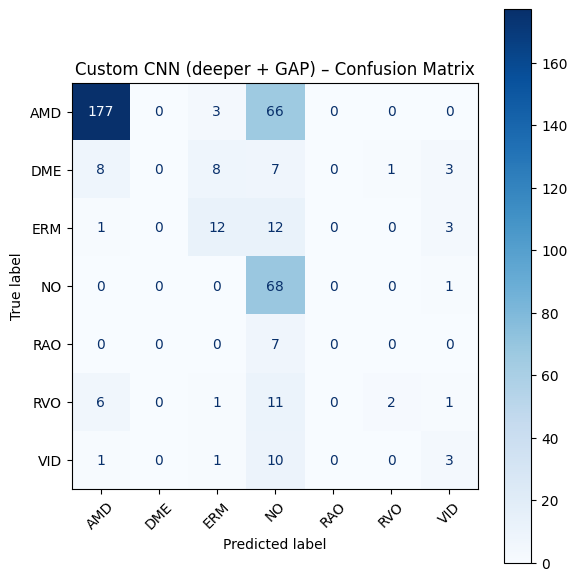

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def eval_and_cm(model, loader, class_names, title="Model"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"{title} – Confusion Matrix")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cm

cm_custom = eval_and_cm(simple_model, val_loader, class_names, title="Custom CNN (deeper + GAP)")


In [7]:
from torchvision import models

# Build ResNet18 with ImageNet weights
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_f = resnet.fc.in_features
resnet.fc = nn.Linear(in_f, len(class_names))   # 7 classes
resnet = resnet.to(device)

criterion_res = nn.CrossEntropyLoss()
optimizer_res = optim.AdamW(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS_RES = 10   # you can increase later
best_val_acc_res = 0.0
best_weights_res = None

for epoch in range(EPOCHS_RES):
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader, criterion_res, optimizer_res)
    va_loss, va_acc, _, _ = eval_one_epoch(resnet, val_loader, criterion_res)

    print(f"[ResNet18] Epoch {epoch+1}/{EPOCHS_RES} - "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc_res:
        best_val_acc_res = va_acc
        best_weights_res = resnet.state_dict().copy()

print("Best val acc (ResNet18):", best_val_acc_res)
if best_weights_res is not None:
    resnet.load_state_dict(best_weights_res)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\pmotha/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [01:12<00:00, 643kB/s] 


[ResNet18] Epoch 1/10 - train loss 0.6651 acc 0.8074 | val loss 0.3705 acc 0.8910
[ResNet18] Epoch 2/10 - train loss 0.1525 acc 0.9564 | val loss 0.3115 acc 0.9007
[ResNet18] Epoch 3/10 - train loss 0.0450 acc 0.9927 | val loss 0.3014 acc 0.9201
[ResNet18] Epoch 4/10 - train loss 0.0300 acc 0.9952 | val loss 0.3291 acc 0.9056
[ResNet18] Epoch 5/10 - train loss 0.0145 acc 0.9988 | val loss 0.2876 acc 0.9298
[ResNet18] Epoch 6/10 - train loss 0.0124 acc 0.9982 | val loss 0.3561 acc 0.9104
[ResNet18] Epoch 7/10 - train loss 0.0081 acc 0.9982 | val loss 0.3280 acc 0.9080
[ResNet18] Epoch 8/10 - train loss 0.0061 acc 0.9988 | val loss 0.3163 acc 0.9153
[ResNet18] Epoch 9/10 - train loss 0.0087 acc 0.9988 | val loss 0.3460 acc 0.9225
[ResNet18] Epoch 10/10 - train loss 0.0173 acc 0.9970 | val loss 0.3620 acc 0.9104
Best val acc (ResNet18): 0.9297820823244553


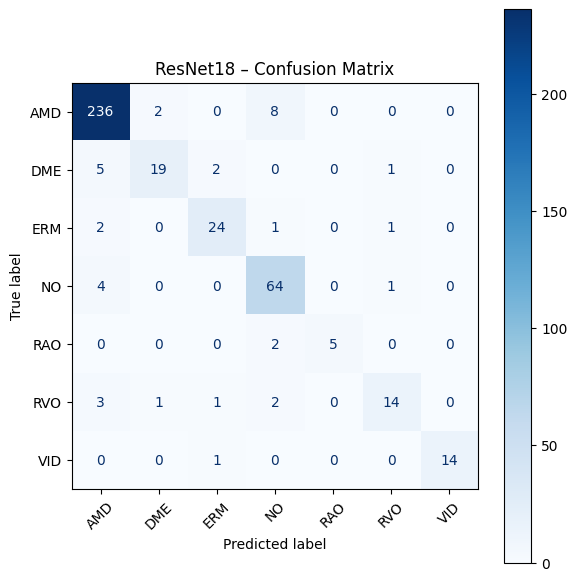

In [8]:
cm_resnet = eval_and_cm(resnet, val_loader, class_names, title="ResNet18")


In [10]:
import numpy as np
import torch


targets = [y for _, y in full_ds]         
targets = np.array(targets)

num_classes = len(class_names)
class_counts = np.bincount(targets, minlength=num_classes)
print("Class counts:", dict(zip(class_names, class_counts)))


inv_freq = 1.0 / class_counts
class_weights = inv_freq / inv_freq.sum() 
print("Class weights:", dict(zip(class_names, class_weights)))

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


Class counts: {'AMD': np.int64(1231), 'DME': np.int64(147), 'ERM': np.int64(155), 'NO': np.int64(332), 'RAO': np.int64(22), 'RVO': np.int64(101), 'VID': np.int64(76)}
Class weights: {'AMD': np.float64(0.009490912290260934), 'DME': np.float64(0.07947831992728714), 'ERM': np.float64(0.07537621309233039), 'NO': np.float64(0.035190701895515694), 'RAO': np.float64(0.5310596831505096), 'RVO': np.float64(0.11567636662684366), 'VID': np.float64(0.15372780301725275)}


In [11]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [12]:
EPOCHS = 20
LR = 1e-3

optimizer = optim.AdamW(simple_model.parameters(), lr=LR, weight_decay=1e-4)

best_val_acc = 0.0
best_weights = None

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_one_epoch(simple_model, train_loader, criterion, optimizer)
    va_loss, va_acc, _, _ = eval_one_epoch(simple_model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_weights = simple_model.state_dict().copy()

print("Best val acc (CNN, weighted CE):", best_val_acc)
if best_weights is not None:
    simple_model.load_state_dict(best_weights)


Epoch 1/20 - train loss 1.0315 acc 0.7795 | val loss 1.3086 acc 0.5230
Epoch 2/20 - train loss 0.9691 acc 0.7589 | val loss 1.0483 acc 0.5860
Epoch 3/20 - train loss 0.9197 acc 0.7753 | val loss 1.1693 acc 0.4165
Epoch 4/20 - train loss 0.8578 acc 0.7717 | val loss 1.9028 acc 0.7385
Epoch 5/20 - train loss 0.8576 acc 0.7735 | val loss 0.9050 acc 0.7627
Epoch 6/20 - train loss 0.7748 acc 0.8007 | val loss 1.1305 acc 0.5835
Epoch 7/20 - train loss 0.7955 acc 0.7704 | val loss 2.1773 acc 0.3850
Epoch 8/20 - train loss 0.7593 acc 0.7844 | val loss 1.0398 acc 0.7748
Epoch 9/20 - train loss 0.7690 acc 0.7916 | val loss 1.3825 acc 0.7797
Epoch 10/20 - train loss 0.7297 acc 0.7892 | val loss 1.8543 acc 0.5714
Epoch 11/20 - train loss 0.7095 acc 0.7892 | val loss 1.7557 acc 0.2978
Epoch 12/20 - train loss 0.7097 acc 0.7959 | val loss 1.4556 acc 0.7627
Epoch 13/20 - train loss 0.7468 acc 0.7801 | val loss 1.3571 acc 0.4891
Epoch 14/20 - train loss 0.8091 acc 0.7589 | val loss 1.2898 acc 0.8039
E

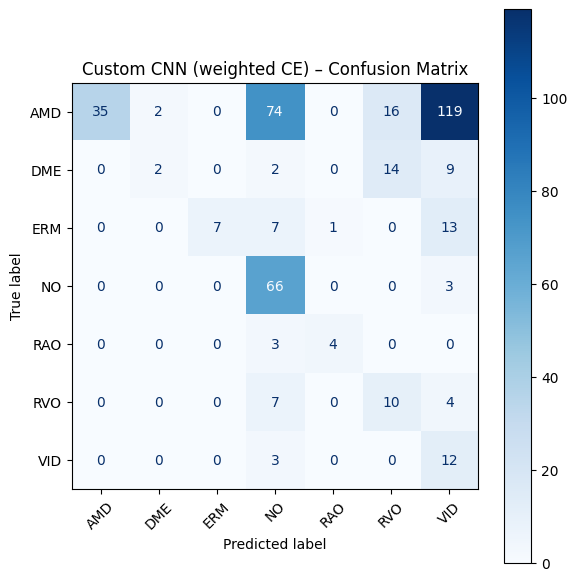

In [13]:
cm_custom_weighted = eval_and_cm(simple_model, val_loader, class_names,
                                 title="Custom CNN (weighted CE)")
